In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn import utils
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#Text Analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from textblob import TextBlob as tb
from IPython.display import Image as im
style.use('fivethirtyeight')

In [6]:
# SVM model imports
model_doc = joblib.load("./Exported_Models/01_svm_model.pkl")
model_beh = joblib.load("./Exported_Models/02_svm_model.pkl")
model_emo = joblib.load("./Exported_Models/03_svm_model.pkl")

# Doc2Vec model imports
doc2vec_doc = Doc2Vec.load("./Exported_Models/doc2vec.model")
doc2vec_beh = Doc2Vec.load("./Exported_Models/behavioral.model")

#test imports
X_test = joblib.load("./Exported_Models/X_test.pkl")
y_test = joblib.load("./Exported_Models/y_test.pkl")
test_orig = joblib.load("./Exported_Models/test.pkl")
test = pd.read_pickle("./Exported_Models/test.pkl")

UnpicklingError: invalid load key, 'x'.

In [ ]:
test.head()

doc ---> 1st model (leftmost)
beh ---> 2nd model (middle)
emo ---> 3rd model (rightmost)

In [ ]:
%run './Utils/COMBINED.ipynb'

In [ ]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

def get_behaviors_string(string):
    if not string: return ""
    
    string = re.sub(r'[^\w]', ' ', string)
    
    res = ""
    
    dic = get_behavior_breakdown(string)

    
    for key in dic:
        arr = dic[key]
        for i in arr:
            res += i + " "
        res += key + " "
        
        
    return res

def doc_infer_vector(string):
    li = tokenize_text(string)
    
    return doc2vec_doc.infer_vector(li)

def beh_infer_vector(string):
    string = get_behaviors_string(string)
    
    li = tokenize_text(string)
    
    return doc2vec_beh.infer_vector(li)

def emo_infer_freq(string):
    freq = get_sentiment_breakdown(string)
    df = pd.DataFrame(columns=["negative", "positive", "fear", "anger", "trust", "sadness", "disgust", "anticip", "surprise", "joy", "anticipation"])
    df = df.append(freq, ignore_index=True)
    df = df.fillna(0)
    return df.iloc[0].tolist()

In [4]:
test["doc_vec"] = test.cleaned_text.apply(lambda x: doc_infer_vector(x))
test["beh_vec"] = test.cleaned_text.apply(lambda x: beh_infer_vector(x))
test["emo_vec"] = test.cleaned_text.apply(lambda x: emo_infer_freq(x))

NameError: name 'test' is not defined

In [7]:
test["doc_label"] = test.doc_vec.apply(lambda x: model_doc.predict(x.reshape(1, -1))[0])

In [8]:
test["beh_label"] = test.beh_vec.apply(lambda x: model_beh.predict(x.reshape(1, -1))[0])

In [9]:
test["emo_label"] = test.emo_vec.apply(lambda x: model_emo.predict([x])[0])

In [10]:
def finalize(a, b, c):
    li = [a, b, c]
    
    def most_frequent(List): 
        counter = 0
        num = List[0] 
      
        for i in List: 
            curr_frequency = List.count(i) 
            if(curr_frequency> counter): 
                counter = curr_frequency 
                num = i 
  
        return num

    return most_frequent(li)

In [11]:
test.head(2)

,narrative,label,cleaned_text,doc_vec,beh_vec,emo_vec,doc_label,beh_label,emo_label
3975,Over the past couple of weeks my anxiety was a...,unwell,past couple weeks anxiety low,"[-0.24891771, 0.16883822, -0.36930078, -0.5204...","[0.00016271167, 0.0007172979, 0.00034254458, 0...","[0.2, 0.0, 0.2, 0.2, 0.0, 0.2, 0.0, 0.0, 0.0, ...",unwell,well,unwell
2932,My last memory of him will be watching him smi...,unwell,last memory watching smirk cried,"[-0.6547103, 0.046092402, -0.6507942, -0.39150...","[-0.053801768, -0.027324012, -0.07217626, -0.0...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",well,well,unwell


In [12]:
test["final"] = test.apply(lambda x: finalize(x.doc_label, x.beh_label, x.emo_label), axis=1)

In [13]:
print(classification_report(test.label, test.final))

              precision    recall  f1-score   support

      unwell       0.93      0.79      0.86       718
        well       0.82      0.94      0.88       708

    accuracy                           0.87      1426
   macro avg       0.88      0.87      0.87      1426
weighted avg       0.88      0.87      0.87      1426



In [14]:
import pandas
from sklearn import tree
import pydotplus
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
from sklearn import metrics

In [15]:
test = test.replace(to_replace = "well", value =1) 
test = test.replace(to_replace = "unwell", value =0) 
test.head()

/usr/local/lib/python3.8/site-packages/pandas/core/missing.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


,narrative,label,cleaned_text,doc_vec,beh_vec,emo_vec,doc_label,beh_label,emo_label,final
3975,Over the past couple of weeks my anxiety was a...,0,past couple weeks anxiety low,"[-0.24891771, 0.16883822, -0.36930078, -0.5204...","[0.00016271167, 0.0007172979, 0.00034254458, 0...","[0.2, 0.0, 0.2, 0.2, 0.0, 0.2, 0.0, 0.0, 0.0, ...",0,1,0,0
2932,My last memory of him will be watching him smi...,0,last memory watching smirk cried,"[-0.6547103, 0.046092402, -0.6507942, -0.39150...","[-0.053801768, -0.027324012, -0.07217626, -0.0...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,0,1
795,He was charged with strangulation based on all...,0,charged strangulation based bruising around ne...,"[0.006851627, 0.092611134, -0.06760383, -0.223...","[0.00029909, -0.0014485997, 0.0014238312, -0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,1,1
112,It was so good and I watched all of the episodes.,1,good watched episodes,"[0.04459169, 0.02408213, 0.021228448, -0.04361...","[0.00016271167, 0.0007172979, 0.00034254458, 0...","[0.0, 0.2, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, ...",1,1,1,1
1944,I was happy when I received my final grades fo...,1,happy received final grades semester realized got,"[-0.40110955, 0.04828734, -0.41592517, -0.2874...","[0.27644315, 0.27498782, -0.23476793, 0.136856...","[0.0, 0.4, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, ...",1,0,1,1


In [16]:
features = ['doc_label', 'beh_label', 'emo_label', 'lexicon_status']

X = test[features]
y = test['label']


In [17]:
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X, y)
data = tree.export_graphviz(dtree, out_file=None, feature_names=features)
graph = pydotplus.graph_from_dot_data(data)

In [18]:
y_pred = dtree.predict(test[features])
print("Accuracy:",metrics.accuracy_score(y, y_pred))

Accuracy: 0.9242636746143057


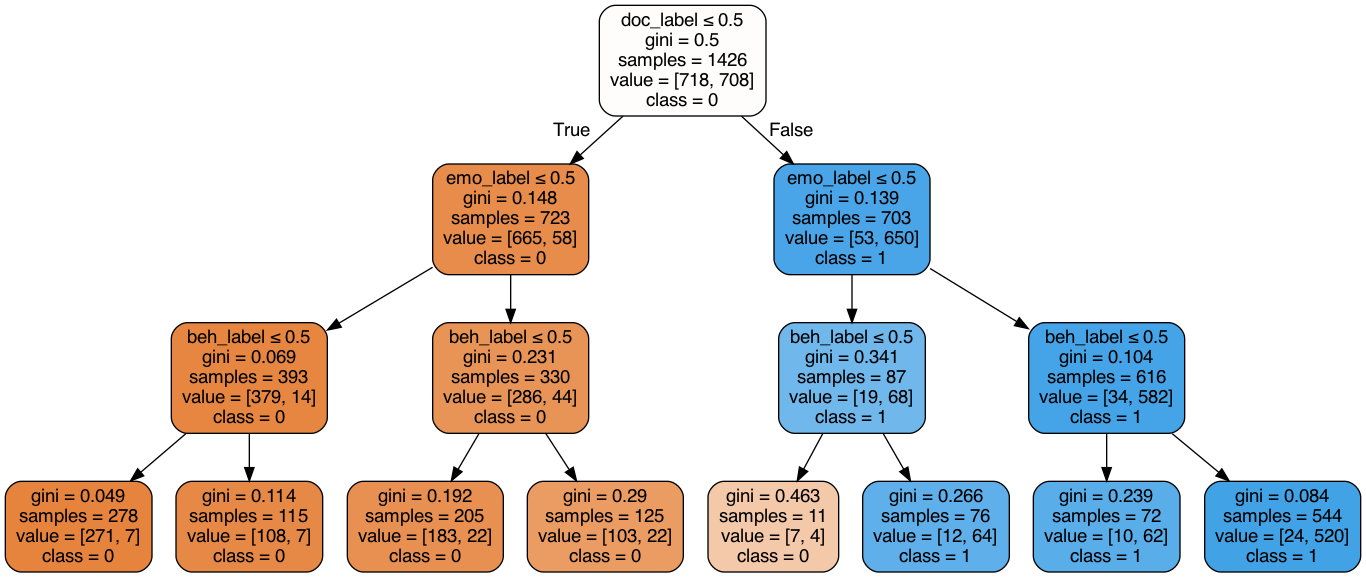

In [28]:
from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO  
from IPython.display import Image  
from six import StringIO
import pydotplus

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = features,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())